# 0. Import Data

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import csv
import math
import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import gps_utils as gps
import time as ttt

In [2]:
current_milli_time = lambda: int(round(ttt.time() * 1000))

with open('../test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    latitude_list = []
    longitude_list = []
    time_list = []
    # breaks only for development purposes
    counter = 0
    time = 0
    
    # for development only
    # test ist eine Liste mit allen Trajectories, jeder Traejctory ist ein (Pandas-) Dataframe mit den Spalten lon, lat, time
    test = []
    
    for row in csv_reader:
        cleared = row[8].replace("],[", " -1 ").replace("[[", "").replace("]]", "")
        if cleared != "POLYLINE":
            splitted = cleared.split(" -1 ")
            # extractes all the points
            for entry in splitted:
                data = entry.split(",")
                latitude_list.append(data[1])
                longitude_list.append(data[0])
                time_list.append(time)
                time += 15
            counter += 1
            time = 0
            # creats a trajectory dataframe
            coords = pd.DataFrame({'lon': longitude_list, 'lat': latitude_list, 'time': time_list})
            test.append(coords)
            # reset everything 
            latitude_list = []
            longitude_list = []
            time_list = []
            # breaks only for development purposes
            if counter == 35:
                break

# 1. Initial Data 

In [3]:
# retrieve the test route
coords = test[16]
coords.lon = coords.lon.astype(float)
coords.lat = coords.lat.astype(float)

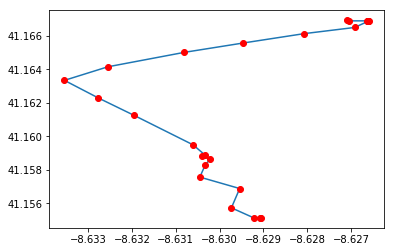

In [4]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [5]:
mplleaflet.display(fig=fig)

# 2. Trajectory Partition

## 2.1. Stop Point Extraction (TDBC)
Referenz: Z. Fu, Z. Tian, Y. Xu, and C. Qiao, ‘‘A two-step clustering approach to extract locations from individual GPS trajectory data,’’ ISPRS Int. J. Geo- Inf., vol. 5, no. 10, p. 166, 2016.

Auch bei Github hochgeladen als spe-tdbc.pdf

In [6]:
def centroid(lonT, latT):
    # https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs
    
    # lonT = [13.341664, 13.374373, 13.376003, 13.352830]
    # latT = [52.519198, 52.523039, 52.504053, 52.508498]
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    
    if (len(lonT) == 0 or len(latT)== 0):
        return 0, 0

    xList = []
    yList = []
    zList = []

    dataT = pd.DataFrame({'lat': latT, 'lon': lonT})
    for index, row in dataT.iterrows():
        lat = row['lat'] * math.pi / 180
        lon = row['lon'] * math.pi / 180
        X = math.cos(lat) * math.cos(lon)
        Y = math.cos(lat) * math.sin(lon)
        Z = math.sin(lat)
        xList.append(X)
        yList.append(Y)
        zList.append(Z)

    dataXYZ = pd.DataFrame({'x': xList, 'y': yList, 'z': zList})

    x = 0
    y = 0
    z = 0
    n = 0

    for index, row in dataXYZ.iterrows():
        x += row['x']
        y += row['y']
        z += row['z']
        n += 1

    aX = x / n
    aY = y / n
    aZ = z / n

    Lon = math.atan2(y, x) * 180 / math.pi
    Hyp = math.sqrt(x * x + y * y)
    Lat = math.atan2(z, Hyp) * 180 / math.pi
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time)
    print("----------centroid(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------centroid(...): END----------")
    
    return Lon, Lat

In [7]:
def stop_point_extraction(trajectory, time_threshold, distance_threshold):
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    # leere Cluster, c_cluster ist Cluster aus dem Paper, p_cluster ist Previous C
    c_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    p_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points_cluster = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
    # p_point ist Previous stop point in SP aus dem Paper, relevant für Zeile 9 und 11 aus dem Paper
    p_point = None
    c_point = None
    # Boolean Flag, nur relevant für die check Funktion
    is_type2 = False
    # braucht man nicht wirklich
    counter = 0

    def start_end(cluster):
        min_time = min(cluster['time'].tolist())
        max_time = max(cluster['time'].tolist())
        return min_time, max_time

    def add_stop_point(cluster):
        # print("-------------------BEGIN: add_stop_point(cluster)---------------------")
        # nonlocal, damit auf die Variablen der übergeordneten Funktion aufgerufen und bearbeiten werden kann
        nonlocal p_cluster
        nonlocal stop_points
        nonlocal stop_points_cluster
        nonlocal c_cluster
        # Variablen Initialisierung
        p_stop_point = None
        # Nur relevant für die Initailisierung des Algorithmuses: wenn kein Stopppunkt vorhanden,
        # füge das aktuelle Cluster oder Punkt der Liste der Stopppunkte hinzu
        # print("-> cluster:")
        # print(cluster)
        min_time, max_time = start_end(cluster)
        if len(stop_points.tail(1)['lon'].values) == 0:
            stop_points = stop_points.append(cluster, ignore_index=True)
            spc_frame = pd.DataFrame(
                {"lon": [cluster['lon'][0]], "lat": [cluster['lat'][0]], "tstart": [cluster['time'][0]]})
            stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
            p_cluster = cluster
            # print("--> initial SP")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        else:
            p_stop_point = stop_points_cluster.tail(1)['lon'].values[0], stop_points_cluster.tail(1)['lat'].values[0]
            cluster_coord = centroid(cluster['lon'].tolist(), cluster['lat'].tolist())
            # gps.haversine(coord1, coord2) berechnet die Distanc in Metern zwischen zwei Koordinaten
            # coord1 und coord2 müssen als Dataframe mit den Spalten lon und lat vorliegen
            # print("-> p_stop_point")
            # print(p_stop_point)
            # print("-> cluster")
            # print(cluster_coord)
            # print("-> distance between cluster and p_stop_point")
            # print(gps.haversine(cluster_coord, p_stop_point))
            if gps.haversine(cluster_coord, p_stop_point) < distance_threshold:
                # hängt alle Punkte des Clusters oder einzelnen Punkt an den p_cluster (vorheriger Cluster)
                p_stop_point_lon, p_stop_point_lat = p_stop_point
                test_point = centroid([p_stop_point_lon], [p_stop_point_lon])
                test_point_frame = pd.DataFrame(
                    {"lon": [p_stop_point_lon], "lat": [p_stop_point_lat], "tstart": [min_time], "tend": [max_time]})
                stop_points = pd.concat([stop_points, cluster]).drop_duplicates().reset_index(drop=True)
                stop_points_cluster = stop_points_cluster.drop(stop_points_cluster.tail(1).index, inplace=True)
                stop_points_cluster = pd.concat([stop_points_cluster, test_point_frame]).drop_duplicates().reset_index(
                    drop=True)
                # print("--> Added c_cluster to p_cluster!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # print("-> c_cluster:")
                # print(c_cluster)
                # print("-> p_cluster:")
                # print(p_cluster)
                c_cluster = c_cluster.iloc[0:0]
            else:
                centeroid_lon, centeroid_lat = cluster_coord
                if centeroid_lon != 0:
                    data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
                    sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
                    stop_points = stop_points.append(cluster, ignore_index=True)
                    stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
                    p_cluster = cluster
                    # Dataframe.iloc[0:0] löscht den Inhalt eines Dataframes, hier den Inhalt von c_cluster
                    c_cluster = c_cluster.iloc[0:0]
                    # print("---> p_cluster = cluster / drop c_cluster")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        # print("-------------------END: add_stop_point(cluster)---------------------")

    def check():
        # print("-------------------BEGIN: check()---------------------")
        nonlocal c_cluster
        nonlocal p_cluster
        nonlocal is_type2
        # centroid(coods, coords) berechnet den Mittelpunkt, Argumente, sind jeweils eine Liste von lon und lat
        c_cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        p_cluster_coord = centroid(p_cluster['lon'].tolist(), p_cluster['lat'].tolist())
        # print("---> BEFORE:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-> time_interval:")
        # print(time_interval())
        # print("-> distance c_cluster_coord, p_cluster_coord:")
        # print(gps.haversine(c_cluster_coord, p_cluster_coord))
        if (time_interval() < time_threshold and gps.haversine(c_cluster_coord, p_cluster_coord) < distance_threshold):
            # p_cluster wird erweitert mit c_cluster, Duplikate werden gelöscht
            p_cluster = p_cluster.append(c_cluster).drop_duplicates().reset_index(drop=True)
            # print("-> p_cluster")
            # print(p_cluster)
            # print("-> is_type2")
            # print(is_type2)
            if is_type2 == True:
                # print("----> add_stop_point(p_cluster)")
                add_stop_point(p_cluster)
                is_type2 == False
                # c_cluster = c_cluster.iloc[0:0]
            else:
                # print("----> p_cluster = c_cluster / drop c_cluster")
                p_cluster = c_cluster
                # löschen des Inhalts von c_cluster
                # c_cluster = c_cluster.iloc[0:0]
        else:
            # pass
            add_stop_point(c_cluster)
        # print("---> AFTER:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-------------------END: check()---------------------")

    def time_interval():
        nonlocal c_cluster
        nonlocal p_cluster
        # wenn p_cluster leer, dann return 0 als Zeitinterval
        if p_cluster.shape[0] == 0:
            return 0
        # berechnet den Zeitinterval von zwei Clustern, indem der Maximalwert (Zeit) der beiden Cluster - Minimalwert
        min_time = min([c_cluster.iloc[[0]]['time'].tolist()[0], p_cluster.iloc[[0]]['time'].tolist()[0]])
        max_time = max([c_cluster.iloc[[-1]]['time'].tolist()[0], p_cluster.iloc[[-1]]['time'].tolist()[0]])
        return abs(max_time - min_time)

    def duration():
        nonlocal c_cluster
        min_time = min(c_cluster['time'].tolist())
        max_time = max(c_cluster['time'].tolist())
        return max_time - min_time

    p_coord = None
    skip = False
    # adds the first and last trajectory points as type 1 stop points
    # if counter == 0 or counter == trajectory.shape[0]-1:

    first_sp_lon = trajectory.iloc[0].values[0]
    first_sp_lat = trajectory.iloc[0].values[1]
    first_sp_frame = pd.DataFrame({"lon": [first_sp_lon], "lat": [first_sp_lat], "time": [0]})
    # print(first_sp_frame)
    add_stop_point(first_sp_frame)
    for index, point in trajectory.iterrows():
        c_point = point
        point_coord = point['lon'], point['lat']
        point_frame = pd.DataFrame({"lon": [point['lon']], "lat": [point['lat']], "time": [point['time']]})
        # print("_____________________________________________________________________________")
        # print(point_frame)
        # print("-> p_coord:")
        # print(p_coord)
        # print("-> point_coord:")
        # print(point_coord)
        # if p_coord != None:
        # print("-> distance between p_coord and point_coord:")
        # print(gps.haversine(p_coord, point_coord))
        # Lösungsvorschlag, wenn der initiale Cluster leer ist, dann füge aktuellen Punkt hinzu
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        # # print(gps.haversine(cluster_coord, point_coord))
        # # print(cluster_coord, point_coord)
        # Punkte des Typ 2 sind der 1,2,3 Fall
        if c_cluster.shape[0] == 0:
            # print("IF -> Cluster empty")
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold:
                # print("----->c_cluster empty: put current point in c_cluster")
                p_p_lon, p_p_lat = p_coord
                p_point_frame = pd.DataFrame({"lon": [p_p_lon], "lat": [p_p_lat], "time": [point['time'] - 15]})
                # if (point['time'] - 15) != 0 :
                c_cluster = c_cluster.append(p_point_frame)
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
            else:
                skip = True
                # print("----->PASS -> p_coord None or distance between p_coord, point_coord < distance_threshold")

        else:
            skip = False
            # print("ELSE -> Cluster not empty and point may be added to cluster")
            if gps.haversine(cluster_coord, point_coord) < distance_threshold:
                # print(">>>case1: put in c_cluster")
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
                is_type2 = True
        if (skip != True):
            # print("Other Cases:")
            # print("-> distance cluster_coord and point_coord")
            # print(gps.haversine(cluster_coord, point_coord))
            # print("-> duration()")
            # print(duration())
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() > time_threshold:
                # print(">>>case2")
                add_stop_point(c_cluster)
                is_type2 = True
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() < time_threshold:
                # print(">>>case3")
                check()
                is_type2 = True
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold and 15 > time_threshold:
                # print(">>>case4")
                is_type2 = False

            if p_coord != None and gps.haversine(p_coord, point_coord) > distance_threshold and 15 > time_threshold:
                # print(">>>case5")
                is_type2 = False
                pass
        # print("<<<----------LOOP RESULTS BEGINN---------->>>")
        # print("-> c_cluster")
        # print(c_cluster)
        # print("-> p_cluster")
        # print(p_cluster)
        # print("-> END: stop_points")
        # print(stop_points)
        # print("-> END: stop_points_cluster")
        # print(stop_points_cluster)
        # print("<<<----------LOOP RESULTS END---------->>>")

        counter += 1
        # p_coord (Vorherige Punkt) wird gesetzt
        p_coord = point['lon'], point['lat']
    if c_cluster.shape[0] == 0:
        p_frame = {'lon': c_point['lon'], 'lat': c_point['lat'], 'time': c_point['time']}
        spc_frame = {"lon": c_point['lon'], "lat": c_point['lat'], "tstart": c_point['time']}
        # stop_points_cluster = stop_points_cluster.append(p_frame, ignore_index=True)
        stop_points = stop_points.append(p_frame, ignore_index=True)
        stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
    else:
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        centeroid_lon, centeroid_lat = cluster_coord
        min_time, max_time = start_end(c_cluster)
        data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
        sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
        stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
        stop_points = stop_points.append(c_cluster, ignore_index=True)
    # print("ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND")
    # print(stop_points_cluster)
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time) 
    print("----------stop_point_extraction(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------stop_point_extraction(...): END----------")

    return stop_points, stop_points_cluster

In [8]:
time_threshold = 500
distance_threshold = 60
stop_points, stop_points_cluster = stop_point_extraction(coords, time_threshold, distance_threshold)

----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 5
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time 

----------create_route: BEGIN----------
time consumption in ms: 10
----------create_route: END----------
         lon        lat time
0  -8.627094  41.166936    0
1  -8.627049  41.166900   15
2  -8.626644  41.166900   30
3  -8.626626  41.166909   45
4  -8.626617  41.166909   60
5  -8.626617  41.166900   75
6  -8.626608  41.166900   90
7  -8.626599  41.166891  105
8  -8.626923  41.166504  120
9  -8.630343  41.158908  255
10 -8.630406  41.158854  270
11 -8.630217  41.158629  285
12 -8.630325  41.158305  300
13 -8.629218  41.155128  360
14 -8.629074  41.155146  375
15 -8.629065  41.155137  390
         lon        lat  tstart   tend
0  -8.627094  41.166936     0.0  120.0
1  -8.628075  41.166135   135.0    NaN
2  -8.629461  41.165577   150.0    NaN
3  -8.630802  41.165019   165.0    NaN
4  -8.632548  41.164155   180.0    NaN
5  -8.633538  41.163345   195.0    NaN
6  -8.632764  41.162292   210.0    NaN
7  -8.631945  41.161248   225.0    NaN
8  -8.630604  41.159493   240.0    NaN
9  -8.630323

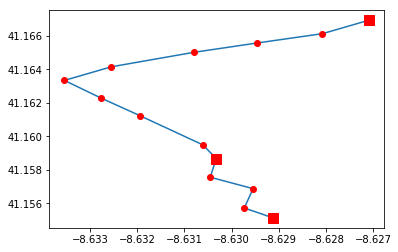

In [9]:
'''
benchmark beginns
'''
start_time = current_milli_time()

new = coords.merge(stop_points,on=['lon','lat'],how='left')
new = new[new.time_y.isnull()]
new = new.rename(columns={"time_x": "tstart", "time_y": "tend"})
route = stop_points_cluster.append(new)
route = route.sort_values(by=['tstart']).reset_index(drop=True)

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------create_route: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------create_route: END----------")

print(stop_points)
print(route)
polt_point_data = route[['lon', 'lat']].values
polt_stop_point_data = stop_points_cluster[['lon', 'lat']].values
plt.plot(polt_point_data[:,0], polt_point_data[:,1])
plt.plot(polt_point_data[:,0], polt_point_data[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

## 2.2. Data Simplification 

In [10]:
'''
benchmark beginns
'''
start_time = current_milli_time()

part = []
simplified_coords = pd.DataFrame(columns=['lon','lat','tstart', 'tend'])
counter = 0
for index, point in route.iterrows():
    counter += 1
    current_point = [point['lon'], point['lat']]
    part.append(current_point)
    if (not math.isnan(point['tend']) and len(part) > 1) or (route.shape[0] == counter) :
        l_data = gps.rdp(part, 0.00025)
        for i in l_data:
            l_lon = i[0]
            l_lat = i[1]
            l_frame = pd.DataFrame({"lon": [l_lon], "lat": [l_lat]})
            simplified_coords = simplified_coords.append(l_frame)
        part = []
        part.append(current_point)
#print(simplified_coords)
#simplified_coords = simplified_coords.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)
#print(simplified_coords)
merged = route.merge(simplified_coords, on=['lon','lat'])
merged = merged.drop(['tstart_y', 'tend_y'], axis=1)
merged = merged.rename(columns={'tstart_x': 'tstart', 'tend_x': 'tend'})
#print(merged)
#print("{} gps points simplified to {} points".format(route.shape[0], simplified_coords.shape[0]))

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------data_simplification(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------data_simplification(...): END----------")

----------data_simplification(...): BEGIN----------
time consumption in ms: 62
----------data_simplification(...): END----------


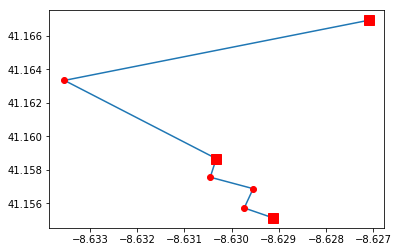

In [11]:
fig = plt.figure()
simplified_coords_plot = simplified_coords[['lon', 'lat']].values
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1])
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

In [12]:
mplleaflet.display(fig=fig)

## 2.3. CSV Writer

In [13]:
'''
benchmark beginns
'''
start_time = current_milli_time()

p_point = pd.Series([])
p_point_e = False
header = False
lts = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
for index, point in merged.iterrows():
    if p_point_e == False:
        pass
    else:
        # # print(point)
        brng = gps.bearingCalculator((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        dis = gps.haversine((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        lts_frame = pd.DataFrame(
            {'lon1': [p_point['lon']], 'lat1': [p_point['lat']], 'tstart1': [p_point['tstart']],
            'tend1': [p_point['tend']],
                 'lon2': [point['lon']], 'lat2': [point['lat']], 'tstart2': [point['tstart']], 'tend2': [point['tend']],
                 'distance': [dis], 'bearing': [brng]})
        lts = lts.append(lts_frame)
        # print(p_point, point)
        # print(brng, dis)
        p_point = point
        p_point_e = True

lts = lts.reset_index(drop=True)
    # print(lts)
if header == False:
    header = True
    lts.to_csv('test_lts.csv', header=True, sep=';', mode='w')  # header = 'False', index = 'True')
else:
    lts.to_csv('test_lts.csv', header=False, sep=';', mode='a')  # header = 'False', index = 'True')

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------write_to_csv(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------write_to_csv(...): END----------")



----------write_to_csv(...): BEGIN----------
time consumption in ms: 8
----------write_to_csv(...): END----------


## 2.4. Common  Segment  Discovery 

In [13]:
routes = []
points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
p_points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
with open('test_lts.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    header = True
    p_index = -1
    for row in csv_reader:
        #polt_point_data = route[['lon', 'lat']].values
        if header == True:
            header = False
        else:
            if p_index >= 0 and int(row[0]) == 0:
                p_points = p_points.append(df_alt, ignore_index=True)
                routes.append(p_points)
                points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
            df = {'lon': float(row[1]), 'lat': float(row[2]), 'tstart': float(row[3]), 'tend': row[4]}
            df_alt = {'lon': float(row[5]), 'lat': float(row[6]), 'tstart': float(row[7]), 'tend': row[8]}
            points = points.append(df, ignore_index=True)
            p_index = int(row[0])
            p_points = points

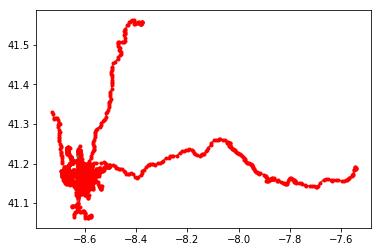

In [14]:
fig = plt.figure()
counter = 0
for test in routes:
    
    plot = test[['lon', 'lat']].values
    plt.plot(plot[:,0], plot[:,1])
    plt.plot(plot[:,0], plot[:,1], 'ro', markersize=3)
    counter += 1
plt.show()

In [15]:
mplleaflet.show(fig=fig)

### 2.4.3. Segment

#### testdata and ploting

In [15]:
l1_lon = [13.333203, 13.323440]
l1_lat = [52.513379, 52.512739]
r4_lon = [13.323687, 13.324814, 13.325855]
r4_lat = [52.512674, 52.512680, 52.512876]
r2_lon = [13.333053, 13.329931, 13.329727, 13.327174, 13.325543]
r2_lat = [52.513470, 52.513235, 52.513052, 52.512876, 52.513020]
r3_lon = [13.327722, 13.330393, 13.331648, 13.333343]
r3_lat = [52.513202, 52.513000, 52.513209, 52.513777]

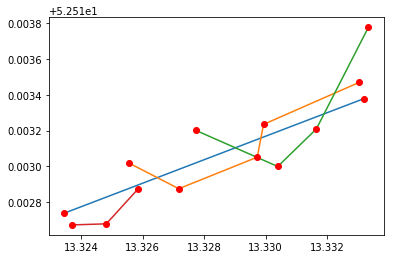

In [16]:
fig = plt.figure()
plt.plot(l1_lon, l1_lat)
plt.plot(r2_lon, r2_lat)
plt.plot(r3_lon, r3_lat)
plt.plot(r4_lon, r4_lat)
plt.plot(l1_lon, l1_lat, 'ro')
plt.plot(r2_lon, r2_lat, 'ro')
plt.plot(r3_lon, r3_lat, 'ro')
plt.plot(r4_lon, r4_lat, 'ro')

In [17]:
mplleaflet.display(fig=fig)

#### building a Pandas data frame from the test data so it is a LG = {L1, L2,...,Ln}

In [18]:
l1 = pd.DataFrame({'lon': l1_lon, 'lat': l1_lat})
r2 = pd.DataFrame({'lon': r2_lon, 'lat': r2_lat})
r3 = pd.DataFrame({'lon': r3_lon, 'lat': r3_lat})
r4 = pd.DataFrame({'lon': r4_lon, 'lat': r4_lat})
lg = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
list_of_lg = [l1, r2, r3, r4]
p_p = None
for entry in list_of_lg:
    time = 0
    for c_p in entry.iterrows():
        if p_p != None and c_p[0] == 0:
            p_p = None
        if p_p != None:
            index = p_p[0]
            brng = gps.bearingCalculator((p_p[1][0], p_p[1][1]), (c_p[1][0], c_p[1][1]))
            dis = gps.haversine((p_p[1][0], p_p[1][1]), (c_p[1][0], c_p[1][1]))
            df = pd.DataFrame({
                'lon1': p_p[1][0], 
                'lat1': p_p[1][1], 
                'tstart1': time - 15, 
                'tend1': time, 
                'lon2': c_p[1][0], 
                'lat2': c_p[1][1], 
                'tstart2': time , 
                'tend2': time + 15, 
                'distance': dis, 
                'bearing': brng
            }, index=[index])
            lg = lg.append(df)
        p_p = c_p
        p_time = time
        time += 15
print(lg)

        lon1       lat1 tstart1 tend1       lon2       lat2 tstart2 tend2  \
0  13.333203  52.513379       0    15  13.323440  52.512739      15    30   
0  13.333053  52.513470       0    15  13.329931  52.513235      15    30   
1  13.329931  52.513235      15    30  13.329727  52.513052      30    45   
2  13.329727  52.513052      30    45  13.327174  52.512876      45    60   
3  13.327174  52.512876      45    60  13.325543  52.513020      60    75   
0  13.327722  52.513202       0    15  13.330393  52.513000      15    30   
1  13.330393  52.513000      15    30  13.331648  52.513209      30    45   
2  13.331648  52.513209      30    45  13.333343  52.513777      45    60   
0  13.323687  52.512674       0    15  13.324814  52.512680      15    30   
1  13.324814  52.512680      15    30  13.325855  52.512876      30    45   

     distance     bearing  
0  664.494419  177.271975  
0  212.877553  176.887584  
1   24.589488  147.049935  
2  173.869528  177.141530  
3  111.52722

#### lines that belong to the same LTS in LG, are merged into one line, LG = {L,...,Lm,...,Lij}

In [19]:
new_lg = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
f_entry = None
p_entry = None
counter = 0
for entry in lg.iterrows():
    counter += 1
    if (entry[0] == 0 or lg.shape[0] == counter) and counter > 1:
        if lg.shape[0] == counter:
            p_entry = entry
        index = p_entry[0]
        brng = gps.bearingCalculator((f_entry[1][0], f_entry[1][1]), (p_entry[1][4], p_entry[1][5]))
        dis = gps.haversine((f_entry[1][0], f_entry[1][1]), (p_entry[1][4], p_entry[1][5]))
        df = pd.DataFrame({
                'lon1': f_entry[1][0], 
                'lat1': f_entry[1][1], 
                'tstart1': f_entry[1][2], 
                'tend1': f_entry[1][3], 
                'lon2': p_entry[1][4], 
                'lat2': p_entry[1][5], 
                'tstart2': p_entry[1][6] , 
                'tend2': p_entry[1][7], 
                'distance': dis, 
                'bearing': brng
            }, index=[index])
        f_entry = None
        new_lg = new_lg.append(df)
    if entry[0] == 0:
        f_entry = entry
    p_entry = entry
print(new_lg)

        lon1       lat1 tstart1 tend1       lon2       lat2 tstart2 tend2  \
0  13.333203  52.513379       0    15  13.323440  52.512739      15    30   
3  13.333053  52.513470       0    15  13.325543  52.513020      60    75   
2  13.327722  52.513202       0    15  13.333343  52.513777      45    60   
1  13.323687  52.512674       0    15  13.325855  52.512876      30    45   

     distance     bearing  
0  664.494419  177.271975  
3  510.665011  177.511085  
2  385.711525  355.787588  
1  148.421280  356.134498  


#### ploting after merging

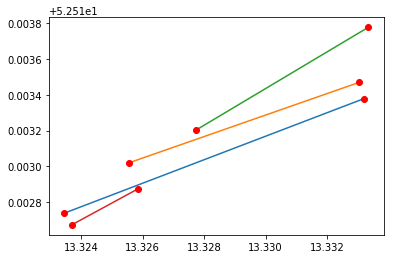

In [20]:
fig = plt.figure()
for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    lon_l.append(p1_lon)
    lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = i[1][5]
    lon_l.append(p2_lon)
    lat_l.append(p2_lat)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')

In [21]:
mplleaflet.display(fig=fig)

#### calculating the representative line of LG, Ax + By + C = 0

the angle θ is the mean angle in LG in:
$$\theta = \frac{1}{k}   \sum_{i=1}^{k} \theta_i, \theta \in [0, \pi)$$